# Homework 3 - Interactive Viz

You can visualise the HW here: https://nbviewer.jupyter.org/github/julied20/ada-2017/blob/master/Homeworks/Homework03/Homework03.ipynb?flush_cache=true

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import folium
import re
import sys
import re
from folium import plugins
import branca.colormap as cm
import branca


from bs4 import BeautifulSoup
import requests

## Methods

### Legends and colors creation

In [2]:
# Color Scale
def unemployment_color(dataframe, element, column, index, colors, name):

    value = float(dataframe.loc[dataframe[name] == element, column].values)
    
    for i in range(0,len(index)):
        if value < 0:
            return '#000000'
        elif value < index[i]:
            return colors[i]
        
    return colors[len(colors)-1]

# Define the legend
def legend(index, colors, vmin, vmax):
    legend_map = cm.StepColormap(
        colors,
        vmin=vmin, vmax=vmax,
        index = index,
        caption='legend_step'
    )
    
    return legend_map

## Question 1 -  European unemployment rates

On the eurostat website, we found our dataset under 'Database by themes/Population and social conditions/Labour Market(labour)/Employment and unemployment/LFS main indicators/Unemployment - LFS adjusted series/Unemployment by sex and age - annual average'. It provides the unemployment rates up to 2016 for all european countries. On the contrary of its name, both sex and all ages are mixed.

### Data Extraction

After finding the CSV file containing the data containing the europeen unemployement rate.

The choice is made to keep the unemployement rate of the year 2016. For the analysis, we can only keep the country name and the unemployement rate.

We can also drop the country that aren't in Europe

Observing the Dataset, it can be seen that 'Germany' is written differently than the others: Germany (until 1990 former territory of the FRG). After cleaning, we can use the Dataset to create a Choropleth map.


In [3]:
CSV_PATH = 'data/question1/une_rt_a_1_Data.csv'

europe_df = pd.read_csv(CSV_PATH) 

#CLeaning Dataset
europe_df = europe_df.loc[europe_df['TIME'] == 2016]
europe_df = europe_df.loc[europe_df['UNIT'] == 'Percentage of active population']
europe_df = europe_df.drop(['TIME','AGE', 'SEX','UNIT','Flag and Footnotes'], axis = 1)
europe_df = europe_df[6:]
europe_df = europe_df[:30]


# Clean Germany's name
for index, row in europe_df.iterrows():
    if 'Germany' in europe_df.loc[index, 'GEO']:
        europe_df.loc[index, 'GEO'] = 'Germany'


europe_df['Value'] = europe_df['Value'].astype(float)

# Delete Cyprus and Malta
europe_df = europe_df[~(europe_df['GEO'] == 'Cyprus')]
europe_df = europe_df[~(europe_df['GEO'] == 'Malta')]

europe_df = europe_df.reset_index( drop = True)
europe_df.head()

,GEO,Value
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany,4.1


We know have a DataFrame containing informations about all UE countries. However, the topojson file contains more countries than our DataFrame, like Israel for example. In order to produce a pertinent plot, we have to 'grey-out' all countries for which we don't have a value. To do so, we will add every new country of the topojson to our dataframe while giving a rate value of -1.

In [4]:
state_topo_path = r'topojson/europe.topojson.json'
topo_json_data = json.load(open(state_topo_path))

In [5]:
length = europe_df.shape[0]
for i in range(0,51):
    present = 0
    for index, row in europe_df.iterrows():
        if row['GEO'] == topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME']:
            present = 1
            presence_row = row
    if present == 0:
        if topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'] == 'Switzerland':
            europe_df.loc[-1] = [topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'],3.5]
        else:
            europe_df.loc[-1] = [topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'],-1]  # adding a row
        europe_df.index = europe_df.index + 1  # shifting index
        europe_df = europe_df.sort_index()

### Choropleth map

In [6]:
index = [3, 4, 6, 8, 10, 12]
colors = ['#fcfcfc','#FAF5D0', '#FAED88', '#FCDF02', '#FABB82','#ff6600','#ff0000']
legend_europe = legend(index, colors, 2, 14)

In [7]:
europe_map = folium.Map([54,17], tiles='cartodbpositron', zoom_start=3.5)

#colorscale = branca.colormap.linear.YlOrRd.to_step(data=europe_df['Value'], n=6)
#colorscale.caption = 'Unemployment Rate'
#colorscale.add_to(europe_map)

    

folium.TopoJson(open(state_topo_path),
               'objects.europe',
               style_function=lambda feature: {
                'fillColor': unemployment_color(europe_df, feature['properties']['NAME'], 'Value', index, colors, 'GEO'),
                'color' : 'black',
                'weight' : 1,
                'opacity': 0.5}).add_to(europe_map)

europe_map

In [8]:
legend_europe

On the graph above, one can observe the unemployment rate for most european countries. For countries which are not part of the EU, nor Switzerland will appear in grey. For all the others, a Standard Deviation Classification is chosen to separate the different unemployment rates, going from white to red while passing through yellow. The standard deviation is valued at 4.5, in order to show bigger differences we will separate the colors by half the standard deviation which is around 2. The countries in light yellow present a rate lower than 4%, yellow with 6%, light orange with 8% , orange with 10% and red for anything above.

### Comparison with Switzerland

Switzerland has already been added to our DataFrame, with an unemployment value of 3.5% taken from [here](https://tradingeconomics.com/switzerland/unemployment-rate) for December 2016. To compare it with others, we use a barplot showing every country unemployment rate listed by decreasing order.

In [9]:
#Remove country without Data
country_without_info = europe_df.index[europe_df['Value'] == -1].values
europe_df = europe_df.drop(country_without_info)

# Sort by descending order
europe_df = europe_df.sort_values(by = ['Value'], ascending = False)
europe_df = europe_df.reset_index(drop = True)


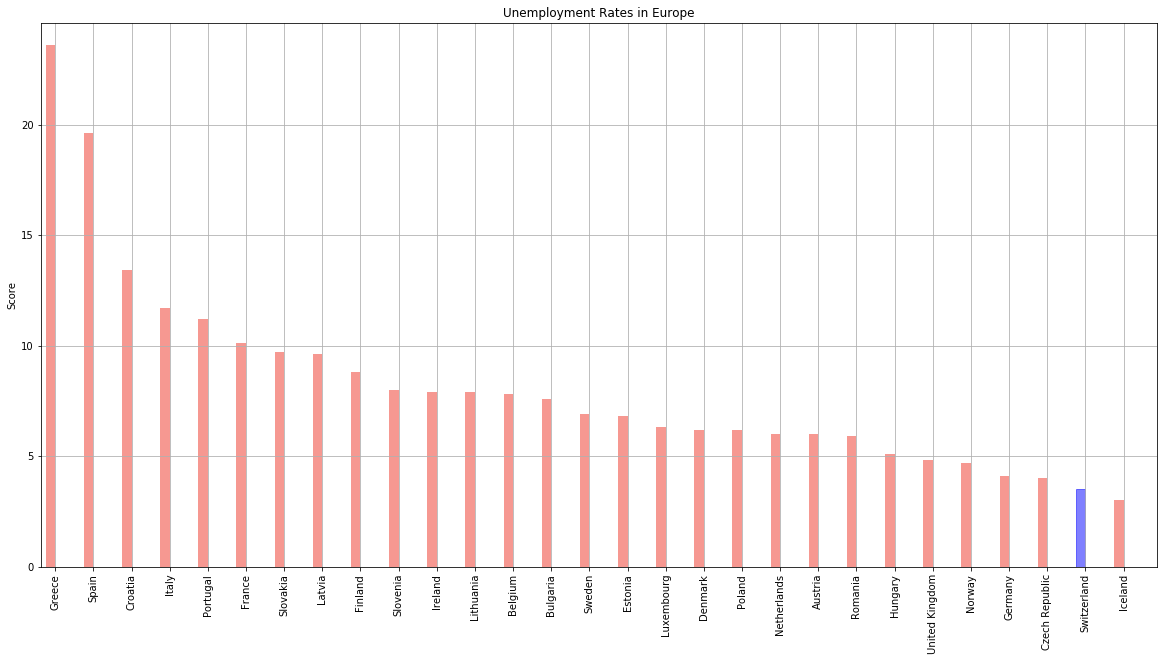

In [10]:
# Setting the positions and width for the bars
pos = list(range(len(europe_df['Value']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with pre_score data,
# in position pos,
barlist = plt.bar(pos, 
        #using df['pre_score'] data,
        europe_df['Value'], 
        width, 
        alpha=0.5, 
        color='#EE3224', 
        label=europe_df['GEO']) 

# Plot Switzerland in blue
barlist[27].set_color('b')

# Set the y axis label
ax.set_ylabel('Score')

# Set the chart's title
ax.set_title('Unemployment Rates in Europe')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(europe_df['GEO'], rotation='vertical')

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(europe_df['Value'])+1] )

# Adding the legend and showing the plot
plt.grid()
plt.show()

The unemployment rate in Switzerland appears much lower than any other European country, with only Iceland showing a lower value.

## Swiss Cantons unemployement

### Methods

#### Extraction and Cleaning of a dataset from a txt file 

In [11]:
def swiss_unemployment_extraction(TXT_PATH):
    switzerland_df = pd.read_table(TXT_PATH, ',') 

    # Cleaning
    switzerland_df = switzerland_df.drop('Mois', 1)
    switzerland_df = switzerland_df.drop(switzerland_df.index[[0]])
    switzerland_df = switzerland_df.drop(switzerland_df.index[[len(switzerland_df) - 1]])
    switzerland_df = switzerland_df.rename(index=str, columns={ "Total" : "Taux de chômage", "Total.1" : "Chômeurs inscrits", "Total.2" : "Demandeurs d'emploi", "Total.3" : "Demandeurs d'emploi non chômeurs"});

    # Replacement of the ' in columns
    switzerland_df["Chômeurs inscrits"] = switzerland_df["Chômeurs inscrits"].str.replace("'", "")
    switzerland_df["Demandeurs d'emploi"] = switzerland_df["Demandeurs d'emploi"].str.replace("'", "")

    # Keep the good columns
    cols = [col for col in switzerland_df.columns if col  in ['Canton', 'Nationalité','Taux de chômage', 'Chômeurs inscrits', "Demandeurs d'emploi", "Demandeurs d'emploi non chômeurs"]]
    switzerland_df = switzerland_df[cols]

    # We have to change the value in float if we want use it. Notice also that the total at the end of the array
    # is the sum of all value, we have to divide by 12 for obtain the average over the year.
    for index, row in switzerland_df.iterrows():
        switzerland_df.loc[index, 'Taux de chômage'] = float(row['Taux de chômage'])
        switzerland_df.loc[index, 'Chômeurs inscrits'] = int(float(row['Chômeurs inscrits'])/12)
        switzerland_df.loc[index, 'Demandeurs d\'emploi'] = int(float(row['Demandeurs d\'emploi'])/12)

    # The colums "Demandeurs d'emploir" value is the value of total asking job people (people who have already a 
    # job and search for a another + people who search and don't have a job)
    switzerland_df['Demandeurs d\'emploi'] =  switzerland_df['Demandeurs d\'emploi']  + switzerland_df['Chômeurs inscrits']
    
    # We compute the total active population and the total rate of "demandeurs d'emploi"
    switzerland_df['Population active'] = switzerland_df['Chômeurs inscrits'] / (switzerland_df['Taux de chômage']/100)
    switzerland_df['Taux demandeurs d\'emploi'] = switzerland_df['Demandeurs d\'emploi'] / switzerland_df['Population active'] * 100

    return switzerland_df

#### Colors, Legend and Map creation

In [12]:
def create_map_swiss(df, column, coordinates, legend):


    canton_topo_path = r'topojson/ch-cantons.topojson.json'
    topo_json_data = json.load(open(canton_topo_path))
    
    m = folium.Map(coordinates, zoom_start=8)
    plugins.ScrollZoomToggler().add_to(m)
    m.choropleth(
        geo_data=open(canton_topo_path),
        topojson='objects.cantons',
        data=df,
        columns=['ID', column],
        key_on='id',
        fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
        legend_name=legend,
        reset=True)
    return m

## Question 2

### Data Extraction

#### From Wikipedia: Extraction of the ID of the Canton

By looking at the topojson of the swiss cantons, we can observe that the cantons are identified by their abreviation. This information is not in the amsat data but we can find them in WIkipedia

In [13]:
# Extract all canton ID from Wikipedia

URL_QS = 'https://fr.wikipedia.org/wiki/Canton_(Suisse)#Données_cantonales'
r = requests.get(URL_QS)
soup = BeautifulSoup(r.text, 'lxml')
    

In [14]:
cantons_ID = []

# We extract all string between tr beacon and who only contain 2 letters
for tr in soup.findAll('tr'):
    tmp = tr.text.split('\n')[1]
    if len(tmp) == 2:
        cantons_ID.append(tmp)
        
del cantons_ID[-1] # Remove the last element which is not a canton

### "People searching a job" Rate in Switzerland

#### Extraction of the Data

In [15]:
TXT_PATH = 'data/question_2_3/DS_Q2.txt'
switzerland_df = swiss_unemployment_extraction(TXT_PATH)

switzerland_df['ID'] = cantons_ID

# Reorganization 
switzerland_df = switzerland_df[['Canton', 'ID', 'Population active', 'Demandeurs d\'emploi', 'Taux demandeurs d\'emploi', 'Chômeurs inscrits' , 'Taux de chômage']]

In [16]:
switzerland_df.head()

,Canton,ID,Population active,Demandeurs d'emploi,Taux demandeurs d'emploi,Chômeurs inscrits,Taux de chômage
1,Zurich,ZH,994189,43487,4.37412,36785,3.7
2,Berne,BE,743852,24885,3.34542,20084,2.7
3,Lucerne,LU,355524,10330,2.90557,7466,2.1
4,Uri,UR,36300,524,1.44353,363,1
5,Schwyz,SZ,127167,3041,2.39135,2289,1.8


#### MAP for total unemployment

In [17]:
# Unemployment total (swiss and foreigner)
create_map_swiss(switzerland_df, 'Taux demandeurs d\'emploi', [46.8,8.2],'Unemployment Rate')

### Total unemployment without people who already have a job

In [18]:
# Unemployment total (swiss and foreigner)
create_map_swiss(switzerland_df, 'Taux de chômage', [46.8,8.2],'Unemployment Rate')


Both maps are very similar. The map displaying the unemployment ignoring the people who already have a job shows that  a big part of the population is actively looking for another job while having one.


The cantons with the highest unemployment rate are the cantons near the borders. This can be explained by the fact that in these cantons, people are coming from other countries to work here.

## Foreign workers in Switzerland

In [19]:
TXT_PATH = 'data/question_2_3/chomage_2016_etrangers_suisses.txt'
switzerland_nationality_df = swiss_unemployment_extraction(TXT_PATH)

In [20]:
previous_canton = 'None'
foreign_unempl = 0
swiss_diff_df = pd.DataFrame(columns=['Canton','ID','Difference Foreigners-Locals'])


# Create a new DataFrame that contains the differences and the ID for each canton
# As all cantons gets two lines (one for locals and one for foreigners), we also reunite them with an if statement
for index, row in switzerland_nationality_df.iterrows():
    if row['Canton'] == previous_canton:
        swiss_diff_df.loc[-1] = [row['Canton'],'NaN',float(foreign_unempl) - float(row['Taux de chômage'])]
        swiss_diff_df.index = swiss_diff_df.index + 1  # shifting index
    else:
        previous_canton = row['Canton']
        foreign_unempl = row['Taux de chômage']
        
swiss_diff_df['ID'] = cantons_ID
swiss_diff_df = swiss_diff_df.reset_index(drop = True)

### Difference in unemployment rates between locals and foreigners in each canton

In [21]:
swiss_diff_df.head()

,Canton,ID,Difference Foreigners-Locals
0,Zurich,ZH,3.2
1,Berne,BE,4.5
2,Lucerne,LU,3.2
3,Uri,UR,3.6
4,Schwyz,SZ,2.7


In [22]:
create_map_swiss(swiss_diff_df, 'Difference Foreigners-Locals', [46.8,8.2],'Difference of Rate')

The colorscale chosen in the map above depends on the Standard Deviation Classification. By observing the values of the Difference in unemployment rates, we notice that the standard deviation of the data is equal to $std = 0.9$. Therefore, we define the minimum of our colorscale at 1.1 (the minimum value) and progress with one $\sigma$ at a time.

The two Cantons where we observe the lowest value are Geneva and Obwald. Two cantons that are drastically different in their nature. Geneva lies next to the border with France, therefore a lot of 'frontaliers' (people living in France and working in Geneva) won't be counted for the unemployment rate, as the foreigners will live in France where life is less expensive. On another hand, Obwald is a central canton, located south of Lucerne. Here, the low number of foreigners might explain this low rate. 

One observation for the highest rates comes from the absence of big cities in them. For example, Jura and Valais are both next to a border, but they present a lack of attractive cities for foreigners to come and jobs to flourish.

### Difference in unemployment rates between age groups

In [23]:
TXT_PATH = 'data/question_2_3/jeune_vieux.txt'

age_df = pd.read_table(TXT_PATH, ',') 
age_df = age_df.drop(['25-49','Septembre 2017','Mesures','Coefficients de variation', 'Chômeurs inscrits','Taux de chômage.1','Total','Total_N','Total2'], axis = 1)
age_df = age_df.rename(index=str, columns={ "Classes d'âge 15-24" : "Age"});
age_df = age_df[:78]

age_df.head()

,Canton,Age,Taux de chômage
0,Zurich,1.0,3.7
1,Zurich,2.0,3.4
2,Zurich,3.0,2.9
3,Berne,1.0,2.8
4,Berne,2.0,2.5


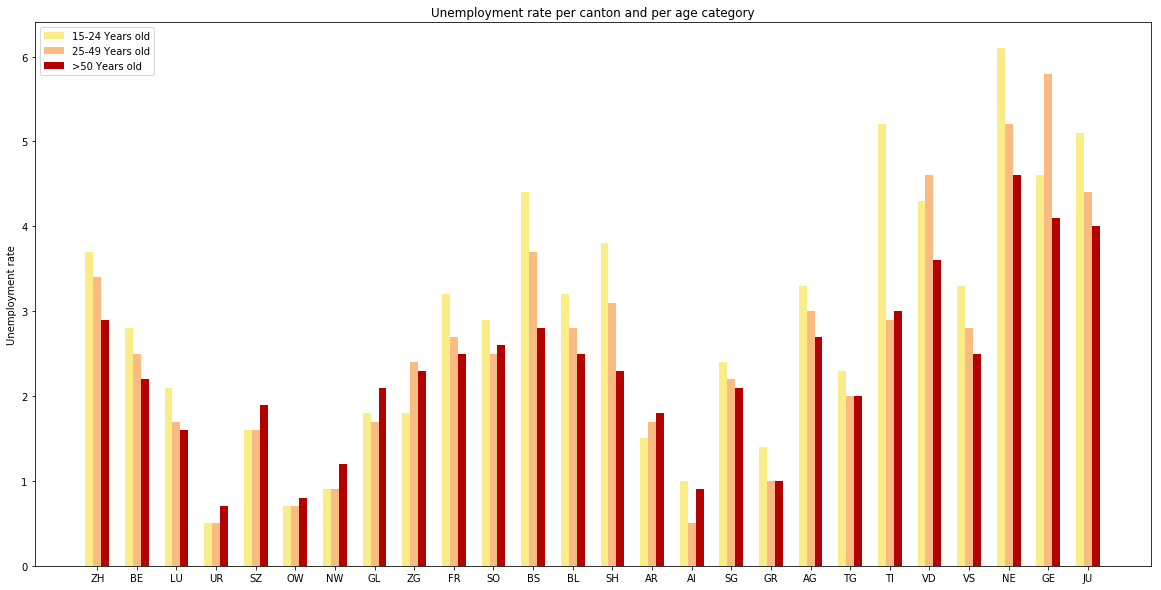

In [24]:

N = 26
young = age_df[age_df['Age']==1]
young = young['Taux de chômage'].values

ind = np.arange(N)  # the x locations for the groups
width = 0.2       # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, young, width, color='#FAED88')

middle = age_df[age_df['Age']==2]
middle = middle['Taux de chômage'].values
rects2 = ax.bar(ind + width,middle, width, color='#FABB82')

old = age_df[age_df['Age']==3]
old = old['Taux de chômage'].values
rects3 = ax.bar(ind + 2*width,old, width, color='#b30000')


# add some text for labels, title and axes ticks
ax.set_ylabel('Unemployment rate')
ax.set_title('Unemployment rate per canton and per age category')
ax.set_xticks(ind + width)
ax.set_xticklabels(cantons_ID)

ax.legend((rects1[0], rects2[0],rects3[0]), ('15-24 Years old', '25-49 Years old','>50 Years old'))

plt.show()

From the plot above, we can first observe that the age category suffering the most from unemployment is the younger one (15-24 years old), even if the values stay relatively low in comparison to other european countries. In most cantons, the ones with the higher unemployment rate will be the older ones (>50 years old).

## Röstigraben

_ *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?_

We can approximately say that the Röstigraben divide the swiss in two part : french speaking part and the german/italian part. We considere Bern as a german speaking canton and Freiburg and Valais as french speaking canton for simplification reason.


In [25]:
french_swiss = ['FR','VD','GE','JU','VS','NE']

unemploy_swiss_fr, pop_swiss_fr = 0, 0
unemploy_swiss_ge, pop_swiss_ge = 0, 0

for i in range(0,len(switzerland_df)):
    if switzerland_df['ID'][i] in french_swiss:
        unemploy_swiss_fr += switzerland_df['Chômeurs inscrits'][i]
        pop_swiss_fr += switzerland_df['Population active'][i]
    
    if ~(switzerland_df['ID'][i] in french_swiss):
        unemploy_swiss_ge += switzerland_df['Chômeurs inscrits'][i]
        pop_swiss_ge += switzerland_df['Population active'][i]
        
print("Unemployement French speaking Swiss ", round(unemploy_swiss_fr/pop_swiss_fr*100,2))
print("Unemployement German speaking Swiss ", round(unemploy_swiss_ge/pop_swiss_ge*100,2))

Unemployement French speaking Swiss  4.45
Unemployement German speaking Swiss  3.26


We can see that the swiss french speaking people  are more lazy 